# Outer Age story alternate

Can we show anything with the histogram data at all?

- Remove the outliers in the age data (or actually average data annually?)
- Can only use 110 or 130 for now (v2.3 will solve this)

In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import xarray as xr
from cmip6_preprocessing.postprocessing import concat_members
import warnings
from dask.diagnostics import ProgressBar

from busecke_etal_2021_aguadv.utils import load_zarr_directory
from busecke_etal_2021_aguadv.plotting import o2_model_colors, model_color_legend

from xarrayutils.plotting import shaded_line_plot
from xarrayutils.utils import linear_trend

In [ ]:
hist_slice = slice('1950', '2000')
trend_slice = slice('2000', '2100')

In [ ]:
def slope(da):
    assert len(da.time) < 300 # make sure the data is annual
    return linear_trend(da.sel(time=trend_slice), 'time').slope * 100

In [ ]:
fail_age_models = ['MRI-ESM2-0','MPI-ESM1-2-HR','MPI-ESM1-2-LR'] # These are the ones I will not use

# TODO: replace this with just one folder once v2.3 is done
# Then also convert this to a dict and just use `load_zarr_directory
dfolder = '/projects/GEOCLIM/LRGROUP/jbusecke/projects_data/cmip6_depth_histogram_v2.1/'
dfolder_patch = "/projects/GEOCLIM/LRGROUP/jbusecke/projects_data/cmip6_depth_histogram_v2.2/"


ddict = load_zarr_directory(dfolder)
ddict_patch = load_zarr_directory(dfolder_patch, pattern="*GFDL*.zarr")


# patch in the newer GFDL datasets (this can be removed once all data is reprocessed)
# remove the GFDL ones from the old
## correct a bug in the processing (I took the sum in time and not the mean)
# Remove this once v2.3 is done (comparison is just needed to confirm this conversion works)
warnings.warn('REMOVE THIS WHEN USING THE NEWER VERSION (>=2.3)')
def _patch(ds):
    attrs = ds.attrs
    if len(ds.time)>300:
        raise RuntimeError('This is a monthly dataset?')
    ds = ds/12 # accidentally saved yearly sum, not mean
    ds.attrs = attrs
    return ds

for k,ds in ddict_patch.items():
    ddict[k] = _patch(ds)

In [5]:
ddict['none.CCCma.CanESM5-CanOE.none.r1i1p2f1.Omon.gn.v20190429.none'].o2_bin_bounds.load().data.astype(int)

array([[  -100,      0,      5,     10,     15,     20,     25,     30,
            35,     40,     45,     50,     55,     60,     65,     70,
            75,     80,     85,     90,     95,    100,    105,    110,
           115,    120,    125,    130,    135,    140,    145,    150,
           155],
       [     0,      5,     10,     15,     20,     25,     30,     35,
            40,     45,     50,     55,     60,     65,     70,     75,
            80,     85,     90,     95,    100,    105,    110,    115,
           120,    125,    130,    135,    140,    145,    150,    155,
        100000]])

In [6]:
ddict['none.NOAA-GFDL.GFDL-CM4.none.r1i1p1f1.Omon.gn.none.none'].o2_bin_bounds.load().data.astype(int)

array([[  -100,      0,      5,     10,     15,     20,     25,     30,
            50,     70,     90,    110,    130,    150,    170],
       [     0,      5,     10,     15,     20,     25,     30,     50,
            70,     90,    110,    130,    150,    170, 100000]])

In [7]:
for n,ds in ddict.items():
    print(f"{n}: {len(ds.o2_bin.data)}")

none.CCCma.CanESM5.none.r5i1p1f1.Omon.gn.v20190429.none: 33
none.MOHC.UKESM1-0-LL.none.r1i1p1f2.Omon.gn.none.none: 33
none.MIROC.MIROC-ES2L.none.r8i1p1f2.Omon.gn.none.none: 33
none.none.none.none.none.none.none.none.none: 33
none.IPSL.IPSL-CM6A-LR.none.r6i1p1f1.Omon.gn.none.none: 33
none.MIROC.MIROC-ES2L.none.r1i1p1f2.Omon.gn.none.none: 33
none.MPI-M.MPI-ESM1-2-LR.none.r3i1p1f1.Omon.gn.none.none: 33
none.CSIRO.ACCESS-ESM1-5.none.r3i1p1f1.Omon.gn.v20191203.none: 33
none.MIROC.MIROC-ES2L.none.r6i1p1f2.Omon.gn.none.none: 33
none.IPSL.IPSL-CM6A-LR.none.r14i1p1f1.Omon.gn.none.none: 33
none.MIROC.MIROC-ES2L.none.r2i1p1f2.Omon.gn.none.none: 33
none.CCCma.CanESM5.none.r6i1p2f1.Omon.gn.v20190429.none: 33
none.CSIRO.ACCESS-ESM1-5.none.r4i1p1f1.Omon.gn.none.none: 33
none.CCCma.CanESM5.none.r2i1p2f1.Omon.gn.v20190429.none: 33
none.MPI-M.MPI-ESM1-2-LR.none.r6i1p1f1.Omon.gn.none.none: 33
none.CSIRO.ACCESS-ESM1-5.none.r2i1p1f1.Omon.gn.none.none: 33
none.CNRM-CERFACS.CNRM-ESM2-1.none.r2i1p1f2.Omon.gn.

In [18]:
ddict_filtered = {}
for name, ds in ddict.items():
    if not 'time' in ds.dims:
        ddict_filtered[name] = ds
    else:
        ds = ds.sel(time=slice('1850', '2100'))
        if len(ds.time) > 1000:
            print(f"Annual average {name}")
            ds = ds.coarsen(time=12).mean()
        try:
            assert len(ds.time) == 251
            ddict_filtered[name] = ds
        except:
            print(name, len(ds.time))
            print(ds.time[0].data)
            print(ds.time[-1].data)

Annual average none.CCCma.CanESM5.none.r5i1p1f1.Omon.gn.v20190429.none
Annual average none.MOHC.UKESM1-0-LL.none.r1i1p1f2.Omon.gn.none.none
Annual average none.MIROC.MIROC-ES2L.none.r8i1p1f2.Omon.gn.none.none
Annual average none.IPSL.IPSL-CM6A-LR.none.r6i1p1f1.Omon.gn.none.none
Annual average none.MIROC.MIROC-ES2L.none.r1i1p1f2.Omon.gn.none.none
Annual average none.MPI-M.MPI-ESM1-2-LR.none.r3i1p1f1.Omon.gn.none.none
Annual average none.CSIRO.ACCESS-ESM1-5.none.r3i1p1f1.Omon.gn.v20191203.none
Annual average none.MIROC.MIROC-ES2L.none.r6i1p1f2.Omon.gn.none.none
Annual average none.IPSL.IPSL-CM6A-LR.none.r14i1p1f1.Omon.gn.none.none
Annual average none.MIROC.MIROC-ES2L.none.r2i1p1f2.Omon.gn.none.none
Annual average none.CCCma.CanESM5.none.r6i1p2f1.Omon.gn.v20190429.none
Annual average none.CSIRO.ACCESS-ESM1-5.none.r4i1p1f1.Omon.gn.none.none
Annual average none.CCCma.CanESM5.none.r2i1p2f1.Omon.gn.v20190429.none
Annual average none.MPI-M.MPI-ESM1-2-LR.none.r6i1p1f1.Omon.gn.none.none
Annual a

In [24]:
def _clean(ds):
    ds = ds.sel(time=slice('1850', '2100'))
    if 'vol' in ds.variables:
        ds = ds.drop('vol')
    if 'dz_t' in ds.variables:
        ds = ds.drop('dz_t')
    return ds

In [25]:
ddict_filtered = {k:_clean(ds) for k,ds in ddict_filtered.items() if 'agessc' in ds.variables}

In [26]:
list(ddict_filtered.keys())

['none.CCCma.CanESM5.none.r5i1p1f1.Omon.gn.v20190429.none',
 'none.MIROC.MIROC-ES2L.none.r8i1p1f2.Omon.gn.none.none',
 'none.IPSL.IPSL-CM6A-LR.none.r6i1p1f1.Omon.gn.none.none',
 'none.MIROC.MIROC-ES2L.none.r1i1p1f2.Omon.gn.none.none',
 'none.MPI-M.MPI-ESM1-2-LR.none.r3i1p1f1.Omon.gn.none.none',
 'none.CSIRO.ACCESS-ESM1-5.none.r3i1p1f1.Omon.gn.v20191203.none',
 'none.MIROC.MIROC-ES2L.none.r6i1p1f2.Omon.gn.none.none',
 'none.IPSL.IPSL-CM6A-LR.none.r14i1p1f1.Omon.gn.none.none',
 'none.MIROC.MIROC-ES2L.none.r2i1p1f2.Omon.gn.none.none',
 'none.CCCma.CanESM5.none.r6i1p2f1.Omon.gn.v20190429.none',
 'none.CSIRO.ACCESS-ESM1-5.none.r4i1p1f1.Omon.gn.none.none',
 'none.CCCma.CanESM5.none.r2i1p2f1.Omon.gn.v20190429.none',
 'none.MPI-M.MPI-ESM1-2-LR.none.r6i1p1f1.Omon.gn.none.none',
 'none.CSIRO.ACCESS-ESM1-5.none.r2i1p1f1.Omon.gn.none.none',
 'none.MPI-M.MPI-ESM1-2-LR.none.r8i1p1f1.Omon.gn.none.none',
 'none.CSIRO.ACCESS-ESM1-5.none.r9i1p1f1.Omon.gn.none.none',
 'none.NCC.NorESM2-MM.none.r1i1p1f1.O

In [27]:
ddict_combined = concat_members(ddict_filtered)

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:113: UserWarning: Match attributes ['experiment_id', 'variable_id'] not found in any of the datasets.         This can happen when several combination functions are used.
  warnings.warn(


In [28]:
list(ddict_combined.keys())

['CanESM5.gn.Omon',
 'MIROC-ES2L.gn.Omon',
 'IPSL-CM6A-LR.gn.Omon',
 'MPI-ESM1-2-LR.gn.Omon',
 'ACCESS-ESM1-5.gn.Omon',
 'NorESM2-MM.gr.Omon',
 'MPI-ESM1-2-HR.gn.Omon',
 'GFDL-ESM4.gn.Omon',
 'GFDL-CM4.gn.Omon',
 'NorESM2-LM.gr.Omon',
 'CanESM5-CanOE.gn.Omon',
 'MRI-ESM2-0.gn.Omon']

CanESM5
[########################################] | 100% Completed | 21min 18.0s
[########################################] | 100% Completed |  1min 37.6s
MIROC-ES2L
[########################################] | 100% Completed |  2min  2.4s
[########################################] | 100% Completed | 54.3s
IPSL-CM6A-LR
[########################################] | 100% Completed | 56.3s
[########################################] | 100% Completed | 27.4s
ACCESS-ESM1-5
[########################################] | 100% Completed |  1min 49.4s
[########################################] | 100% Completed |  4min 57.1s
NorESM2-MM
[########################################] | 100% Completed |  1min 31.7s
[########################################] | 100% Completed |  3.4s
GFDL-ESM4
[########################################] | 100% Completed |  4.6s
[########################################] | 100% Completed |  1.5s
GFDL-CM4


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[########################################] | 100% Completed |  7.7s
[########################################] | 100% Completed |  3.3s
NorESM2-LM


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[########################################] | 100% Completed | 18.0s
[########################################] | 100% Completed | 48.9s
CanESM5-CanOE
[########################################] | 100% Completed |  2min  6.6s
[########################################] | 100% Completed | 23.5s


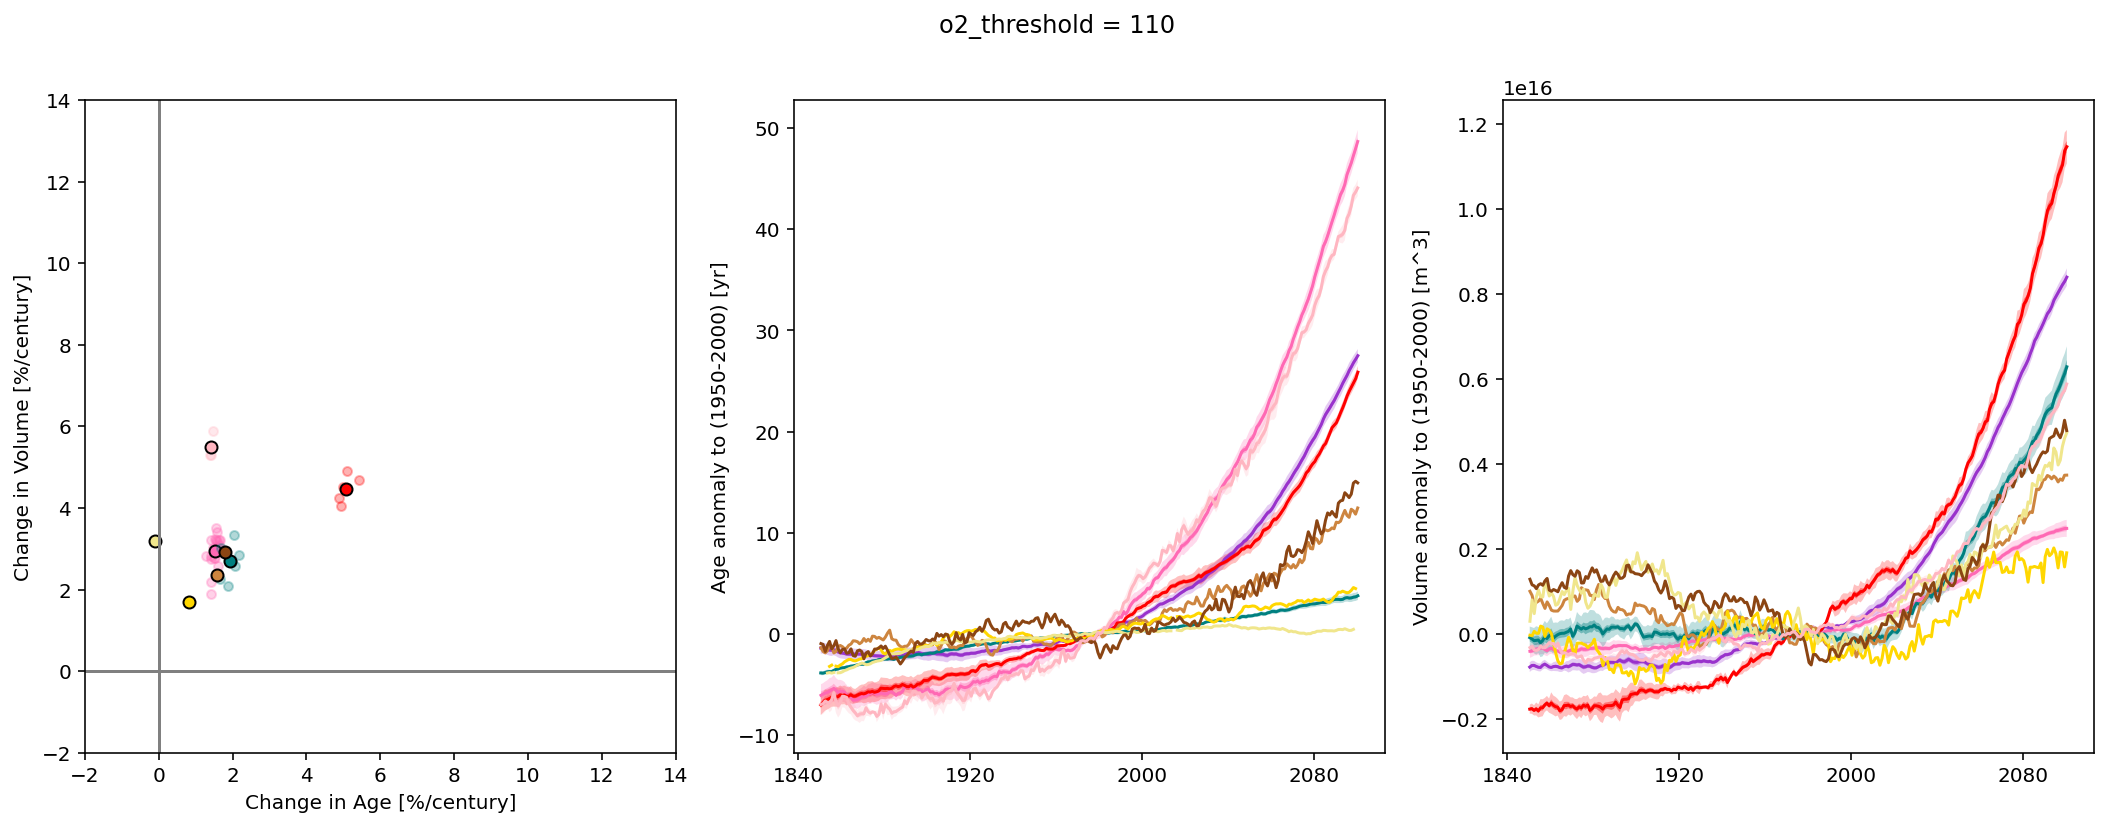

CanESM5
[########################################] | 100% Completed |  5min 29.9s
[########################################] | 100% Completed |  1min 33.6s
MIROC-ES2L
[########################################] | 100% Completed |  1min 58.8s
[########################################] | 100% Completed |  2min  6.4s
IPSL-CM6A-LR
[########################################] | 100% Completed | 57.0s
[########################################] | 100% Completed | 18.8s
ACCESS-ESM1-5
[########################################] | 100% Completed |  3min 37.4s
[########################################] | 100% Completed |  2min 57.5s
NorESM2-MM
[########################################] | 100% Completed | 53.2s
[########################################] | 100% Completed |  4.4s
GFDL-ESM4
[########################################] | 100% Completed |  4.6s
[########################################] | 100% Completed |  1.6s
GFDL-CM4


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[########################################] | 100% Completed | 11.4s
[########################################] | 100% Completed |  3.0s
NorESM2-LM


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[########################################] | 100% Completed | 11.8s
[########################################] | 100% Completed |  4.3s
CanESM5-CanOE
[################################        ] | 81% Completed |  8min 26.3s

In [ ]:
for o2 in [110, 130]:

    fig, (ax_scatter, ax_age, ax_vol) = plt.subplots(ncols=3, nrows=1, figsize=[18, 6])

    for name, ds in ddict_combined.items():
        if ds.source_id not in fail_age_models:
            print(ds.source_id)
            ds_pre = ds.sel(
                basin_mask_bin=['North Pacific Ocean','South Pacific Ocean'],
                lat_bin=slice(-30, 30),
            ).sum(['lat_bin', 'basin_mask_bin', 'lev'])

            ds_inner = ds_pre.sel(o2_bin=slice(None, o2)).sum('o2_bin')
            ds_outer = ds_pre.sel(o2_bin=slice(o2, None)).sum('o2_bin')
            # 150 is not far enough out. This might work better with e.g. 180?

            age = (ds_outer.agessc/ds_outer.volume)
            vol = ds_inner.volume

            if 'member_id' not in age.dims:
                age = age.expand_dims('member_id')

            if 'member_id' not in vol.dims:
                vol = vol.expand_dims('member_id')


            # align the members
            age, vol = xr.align(age, vol, join='inner')


#             age = age.isel(member_id=slice(0,1))
#             vol = vol.isel(member_id=slice(0,1))

            with ProgressBar():
                age = age.load()
                vol = vol.load()

            # this should be unnescessary with proper processing

            if "GFDL" in name:
                age = age.where(age>age.quantile(0.03, 'time'))

            age_hist = age.sel(time=hist_slice).mean('time')
            vol_hist = vol.sel(time=hist_slice).mean('time')

            age_anom = (age - age_hist)
            vol_anom = (vol - vol_hist)

            age_perc = age_anom/ age_hist * 100
            vol_perc = vol_anom/ vol_hist * 100

            age_perc_slope = slope(age_perc)
            vol_perc_slope = slope(vol_perc)

            # plot timeseries of age
            shaded_line_plot(age_anom, 'member_id', ax=ax_age, line_kwargs={'color':o2_model_colors()[ds.source_id]})
            shaded_line_plot(vol_anom, 'member_id', ax=ax_vol, line_kwargs={'color':o2_model_colors()[ds.source_id]})

            ax_scatter.scatter(
                age_perc_slope,
                vol_perc_slope,
                c=o2_model_colors()[ds.source_id],
                alpha=0.3,
                s=10
            )
            ax_scatter.scatter(
                age_perc_slope.mean('member_id'),
                vol_perc_slope.mean('member_id'),
                c=o2_model_colors()[ds.source_id],
                edgecolor='k'
            )

    ax_scatter.set_ylabel('Change in Volume [%/century]')
    ax_scatter.set_xlabel('Change in Age [%/century]')
    ax_scatter.set_xlim(-2, 14)
    ax_scatter.set_ylim(-2, 14)
    ax_scatter.axhline(0, color='0.5')
    ax_scatter.axvline(0, color='0.5')

    ax_age.set_ylabel('Age anomaly to (1950-2000) [yr]')
    ax_vol.set_ylabel('Volume anomaly to (1950-2000) [m^3]')
    fig.suptitle(f'o2_threshold = {o2}')
    plt.show()